In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler

import numpy as np
import gzip
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from tqdm import tqdm
import gc
import time
import random



import sys
sys.path.append('..')
# from slp_package.slp_functions import create_merged_game_data_df
from slp_package.input_dataset import InputDataSet
import slp_package.pytorch_functions as slp_pytorch_functions
from slp_package.slp_functions import create_merged_game_data_df

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using CUDA
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
torch.cuda.is_available()

True

In [2]:
df = create_merged_game_data_df(['ranked','mango','public'])

In [3]:
df.columns


Index(['source', 'source_path_prefix', 'source_path_suffix', 'length',
       'num_players', 'is_teams', 'player_1_port', 'player_1_character_name',
       'player_1_type_name', 'player_1_stocks', 'player_1_costume',
       'player_1_team_value', 'player_1_ucf_shield_drop_name', 'player_1_tag',
       'player_1_display_name', 'player_2_port', 'player_2_character_name',
       'player_2_type_name', 'player_2_stocks', 'player_2_costume',
       'player_2_team_value', 'player_2_ucf_shield_drop_name', 'player_2_tag',
       'player_2_display_name', 'random_seed', 'slippi', 'stage_name',
       'is_pal', 'is_frozen_ps', 'end_method_name', 'lras_initiator',
       'conclusive', 'winning_player', 'date', 'duration', 'platform',
       'player_1_netplay_code', 'player_1_netplay_name',
       'player_2_netplay_code', 'player_2_netplay_name', 'console_name',
       'all_data_df_common_path', 'inputs_df_common_path',
       'inputs_np_common_path', 'player_1_all_data_df_sub_path',
       'player_

In [4]:
df['player_1_display_name'].value_counts()

                   99186
Platinum Player    47335
Master Player      39195
Diamond Player     29613
mang               14142
                   ...  
AV                     1
Zuppy                  1
tk                     1
DawsonTruu             1
Bink                   1
Name: player_1_display_name, Length: 257, dtype: int64

In [5]:
df['length'].sum() / (60)

41459841.06666667

In [6]:
def asses_model(model_name, y_pred, y_test, labels_order):
    print()
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_pred, y_test)

    # Print accuracy and Cohen Kappa score with explanations
    print(f'Accuracy of {model_name}: {accuracy:.4f}')
    print(f'Cohen Kappa Score of {model_name}: {kappa:.4f}')

    # Calculate the normalized predicted label count
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    normalized_counts_pred = {k: v / counts_test[np.where(unique_test == k)[0][0]] for k, v in zip(unique_pred, counts_pred)}
    
    # Calculate the percent the model over or under predicted the labels using the specified label order
    sorted_values = [normalized_counts_pred[k] - 1 if k in normalized_counts_pred else 0 for k in labels_order]

    # Plotting the percent the model over or under predicted the labels
    plt.figure(figsize=(2*len(labels_order), 4))
    plt.bar(labels_order, sorted_values, color=['green' if x > 0 else 'blue' for x in sorted_values])
    plt.title(f'Percent Model {model_name} Over or Under Predicted Labels')
    plt.xlabel('Labels')
    plt.ylabel('Percent Over/Under Prediction')
    
    # Center y-axis and set equal extension above and below
    max_extent = max(abs(min(sorted_values)), abs(max(sorted_values))) * 1.05
    plt.ylim(-max_extent, max_extent)
    plt.axhline(y=0, color='gray', linewidth=0.8)
    plt.show()

    # Display each confusion matrix on its own row
    for norm in [None, 'true', 'pred']:
        plt.figure(figsize=(len(labels_order)+5, len(labels_order)+5))
        ax = plt.gca()
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, normalize=norm, ax=ax,
            xticks_rotation='vertical', labels=labels_order
        )
        ax.title.set_text(f'{model_name} Confusion Matrix ({"Not Normalized" if norm is None else "Normalized by " + norm})')
        plt.tight_layout()
        plt.show()
        



In [7]:
source_data = ['ranked','public','mango']

general_features = {
    'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
    'num_players': [2],
    'conclusive': [True]
}
player_features = {
    # 'netplay_code': ['MANG#0'],
    # 'character_name': ['FALCO'],
    # 'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
    'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'MARIO', 'PEACH', 'ROY', 'LUIGI', 'YOUNG_LINK', 'DONKEY_KONG', 'PICHU', 'KIRBY'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'PEACH', 'LUIGI', 'DONKEY_KONG'],
    'type_name': ['HUMAN']
    
}
opposing_player_features = {
    # 'character_name': ['MARTH'],
    # 'netplay_code': ['KOD#0', 'ZAIN#0']
    'type_name': ['HUMAN']
}
label_info = {
    'source': ['player'], # Can be 'general', 'player
    # 'feature': ['netplay_code']
    'feature': ['character_name']
}

In [8]:
len(['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'MARIO', 'PEACH', 'ROY', 'LUIGI', 'YOUNG_LINK', 'DONKEY_KONG', 'PICHU', 'KIRBY'])

25

In [9]:
# # We classify opponent's characters on competitive stages

# source_data = ['ranked']

# general_features = {
#     'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
#     'num_players': [2],
#     'conclusive': [True]
# }
# player_features = {
#     # 'netplay_code': ['MANG#0'],
#     'character_name': ['FOX'],
#     'type_name': ['HUMAN']
    
# }
# opposing_player_features = {
#     'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
#     # 'netplay_code': ['KOD#0', 'ZAIN#0'],
#     'type_name': ['HUMAN']
# }
# label_info = {
#     'source': ['opposing_player'], # Can be 'general', 'player', 'opposing_player'
#     # 'feature': ['netplay_code']
#     'feature': ['character_name']
# }
    

In [10]:
dataset = InputDataSet(source_data, general_features, player_features, opposing_player_features, label_info)

print(dataset.dataset['labels'].value_counts())

/workspace/slp_jaspar/resnet_classify/../slp_package/input_dataset.py:113: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_df = pd.concat([player_1_df, player_2_df], ignore_index=True)


FOX               103069
FALCO              90719
MARTH              53728
CAPTAIN_FALCON     38006
SHEIK              27623
PEACH              17438
JIGGLYPUFF         16374
SAMUS               9524
ICE_CLIMBERS        6849
GANONDORF           6655
YOSHI               5725
LUIGI               5230
DR_MARIO            4202
PIKACHU             4096
LINK                2502
NESS                2306
DONKEY_KONG         2026
GAME_AND_WATCH      1967
MEWTWO              1775
MARIO               1713
YOUNG_LINK          1447
ROY                 1272
BOWSER               940
KIRBY                556
PICHU                230
Name: labels, dtype: int64


In [11]:
labels_order =  dataset.number_of_segments_per_game(3600,10000)
print(2**10)
print(labels_order)
labels_order = labels_order['Label'].values


1024
             Label   Count  Shift
0              FOX  102551  60300
1            FALCO   90263  51977
2            MARTH   53538  34279
3   CAPTAIN_FALCON   37820  21623
4            SHEIK   27536  19802
5            PEACH   17367  13532
6       JIGGLYPUFF   16214  12008
7            SAMUS    9489   8147
8     ICE_CLIMBERS    6820   5388
9        GANONDORF    6611   4051
10           YOSHI    5704   4089
11           LUIGI    5210   3883
12        DR_MARIO    4177   3046
13         PIKACHU    4067   3049
14            LINK    2489   1914
15            NESS    2291   2091
16     DONKEY_KONG    2009   1452
17  GAME_AND_WATCH    1949   1152
18          MEWTWO    1758   1628
19           MARIO    1710   1306
20      YOUNG_LINK    1430   1128
21             ROY    1262    893
22          BOWSER     934    766
23           KIRBY     531    426
24           PICHU     227    165


In [12]:
train_df, test_df  = dataset.train_test_split_dataframes(test_ratio = .20, val = False)

                           player_inputs_np_sub_path  length  num_segments  \
0  ranked\FALCO\2f51bb81-4304-4c6d-ac53-960aba87c...   26024             1   
1  mango\FALCO\208fe166-c77e-426d-b962-cd595abc58...   23344             1   
2  public\FALCO\b883b42b-3529-4d9b-9d1e-220e16d62...   22841             1   
3  public\FALCO\e22e7cd1-1f9d-46c9-8753-120a2f9e6...   22691             1   
4  ranked\FALCO\e00e51a5-658b-4b90-92ba-15298d018...   21837             1   

  labels  encoded_labels  
0  FALCO               4  
1  FALCO               4  
2  FALCO               4  
3  FALCO               4  
4  FALCO               4  


In [13]:
train_df.head()

,player_inputs_np_sub_path,labels,encoded_labels,segment_start_index,segment_index,segment_length
0,public\FALCO\bee06d45-fca6-437f-969a-901efa166...,FALCO,4,0,0,3600
1,mango\FALCO\b3c63d9d-efb7-4544-bdd6-9da7e221f1...,FALCO,4,0,0,3600
2,mango\FALCO\24b523a3-18da-4ba2-a986-d0c99b6228...,FALCO,4,0,0,3600
3,mango\FALCO\a24ef3f0-ab56-47e6-af18-5905aa43af...,FALCO,4,0,0,3600
4,mango\FALCO\60e0d81b-e0bd-420c-8fce-fe2b11645c...,FALCO,4,0,0,3600


In [14]:
labels_unique = train_df['labels'].unique()
encoded_labels_unique = train_df['encoded_labels'].unique()
label_decoder = zip(labels_unique, encoded_labels_unique)
label_decoder = dict(zip(encoded_labels_unique, labels_unique)) 
print(label_decoder)

{4: 'FALCO', 14: 'MARTH', 5: 'FOX', 1: 'CAPTAIN_FALCON', 22: 'SHEIK', 9: 'JIGGLYPUFF', 3: 'DR_MARIO', 23: 'YOSHI', 19: 'PIKACHU', 21: 'SAMUS', 8: 'ICE_CLIMBERS', 13: 'MARIO', 12: 'LUIGI', 17: 'PEACH', 0: 'BOWSER', 2: 'DONKEY_KONG', 20: 'ROY', 7: 'GANONDORF', 18: 'PICHU', 11: 'LINK', 16: 'NESS', 24: 'YOUNG_LINK', 10: 'KIRBY', 6: 'GAME_AND_WATCH', 15: 'MEWTWO'}


In [15]:
from ResNet_Model import ResNet50, ResNet101
# from ResNet_Model_Relative import ResNet50
# from ResNet_Model_Relative_2 import ResNet50

model = ResNet50(num_classes=25, channels=9).to('cuda')


In [16]:
# # Create a dummy input with the correct shape
# dummy_input = torch.randn(1, 9, 4096)  # batch size of 1, 9 channels, 4096 length
# try:
#     with torch.no_grad():
#         model(dummy_input.to(model.device))  # Ensure the dummy input is on the same device as the model
# except Exception as e:
#     print("Error during test forward pass: ", str(e))



In [17]:
summary(model, input_size=(9, 60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 30]           4,032
       BatchNorm1d-2               [-1, 64, 30]             128
              ReLU-3               [-1, 64, 30]               0
         MaxPool1d-4               [-1, 64, 15]               0
            Conv1d-5               [-1, 64, 15]           4,160
       BatchNorm1d-6               [-1, 64, 15]             128
              ReLU-7               [-1, 64, 15]               0
            Conv1d-8               [-1, 64, 15]          12,352
       BatchNorm1d-9               [-1, 64, 15]             128
             ReLU-10               [-1, 64, 15]               0
           Conv1d-11              [-1, 256, 15]          16,640
      BatchNorm1d-12              [-1, 256, 15]             512
           Conv1d-13              [-1, 256, 15]          16,640
      BatchNorm1d-14              [-1, 

In [ ]:
# model = torch.compile(model, mode = 'default').to('cuda')
# model = torch.compile(model, mode='max-autotune')
# model = model.to('cuda')

In [19]:
loaders = slp_pytorch_functions.prepare_data_loaders_no_val(train_df, test_df, 32, 16)
criterion = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = Adam(model.parameters(), lr=0.001)
gc.collect()
torch.cuda.empty_cache()
# optimizer = SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
slp_pytorch_functions.train_model(model, criterion,optimizer, loaders, 'cuda', 2 )
y_pred = slp_pytorch_functions.predict(model, loaders['test'], 'cuda' )
# y_pred = slp_pytorch_functions.predict(model, loaders['train'], 'cuda' )

Epoch 1/2:   0%|          | 0/6250 [00:00<?, ?batch/s]AUTOTUNE addmm(32x25, 32x2048, 2048x25)
  bias_addmm 0.0082 ms 100.0%
  addmm 0.0092 ms 88.9%
  triton_mm_3 0.0113 ms 72.7%
  triton_mm_4 0.0119 ms 68.6%
  triton_mm_2 0.0125 ms 65.5%
  triton_mm_5 0.0135 ms 60.7%
  triton_mm_1 0.0174 ms 47.2%
  triton_mm_0 0.0225 ms 36.4%
  triton_mm_7 0.0451 ms 18.2%
  triton_mm_6 0.0522 ms 15.7%
SingleProcess AUTOTUNE takes 3.1627 seconds
AUTOTUNE mm(32x25, 25x2048)
  triton_mm_8 0.0041 ms 100.0%
  triton_mm_9 0.0041 ms 100.0%
  triton_mm_10 0.0041 ms 100.0%
  triton_mm_11 0.0041 ms 100.0%
  triton_mm_12 0.0041 ms 100.0%
  triton_mm_14 0.0041 ms 100.0%
  triton_mm_15 0.0041 ms 100.0%
  triton_mm_16 0.0041 ms 100.0%
  triton_mm_18 0.0044 ms 94.1%
  triton_mm_13 0.0048 ms 85.3%
SingleProcess AUTOTUNE takes 2.6350 seconds
AUTOTUNE mm(25x32, 32x2048)
  triton_mm_20 0.0041 ms 100.0%
  triton_mm_22 0.0041 ms 100.0%
  triton_mm_23 0.0041 ms 100.0%
  triton_mm_24 0.0041 ms 100.0%
  triton_mm_26 0.0041 ms


Accuracy of ResNet-50: 0.9583
Cohen Kappa Score of ResNet-50: 0.9566


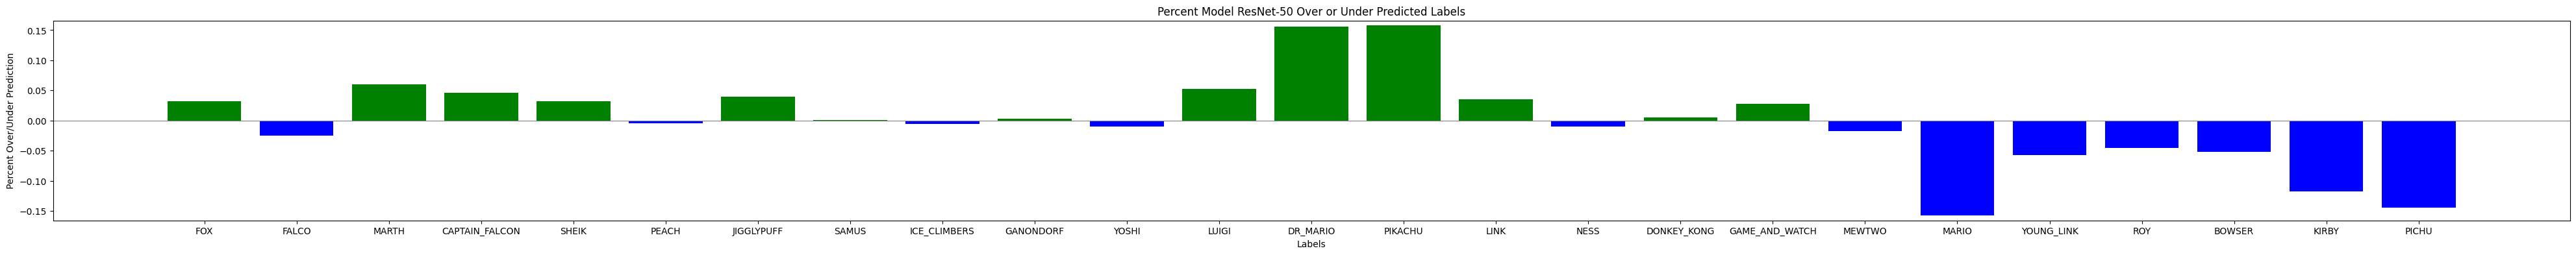

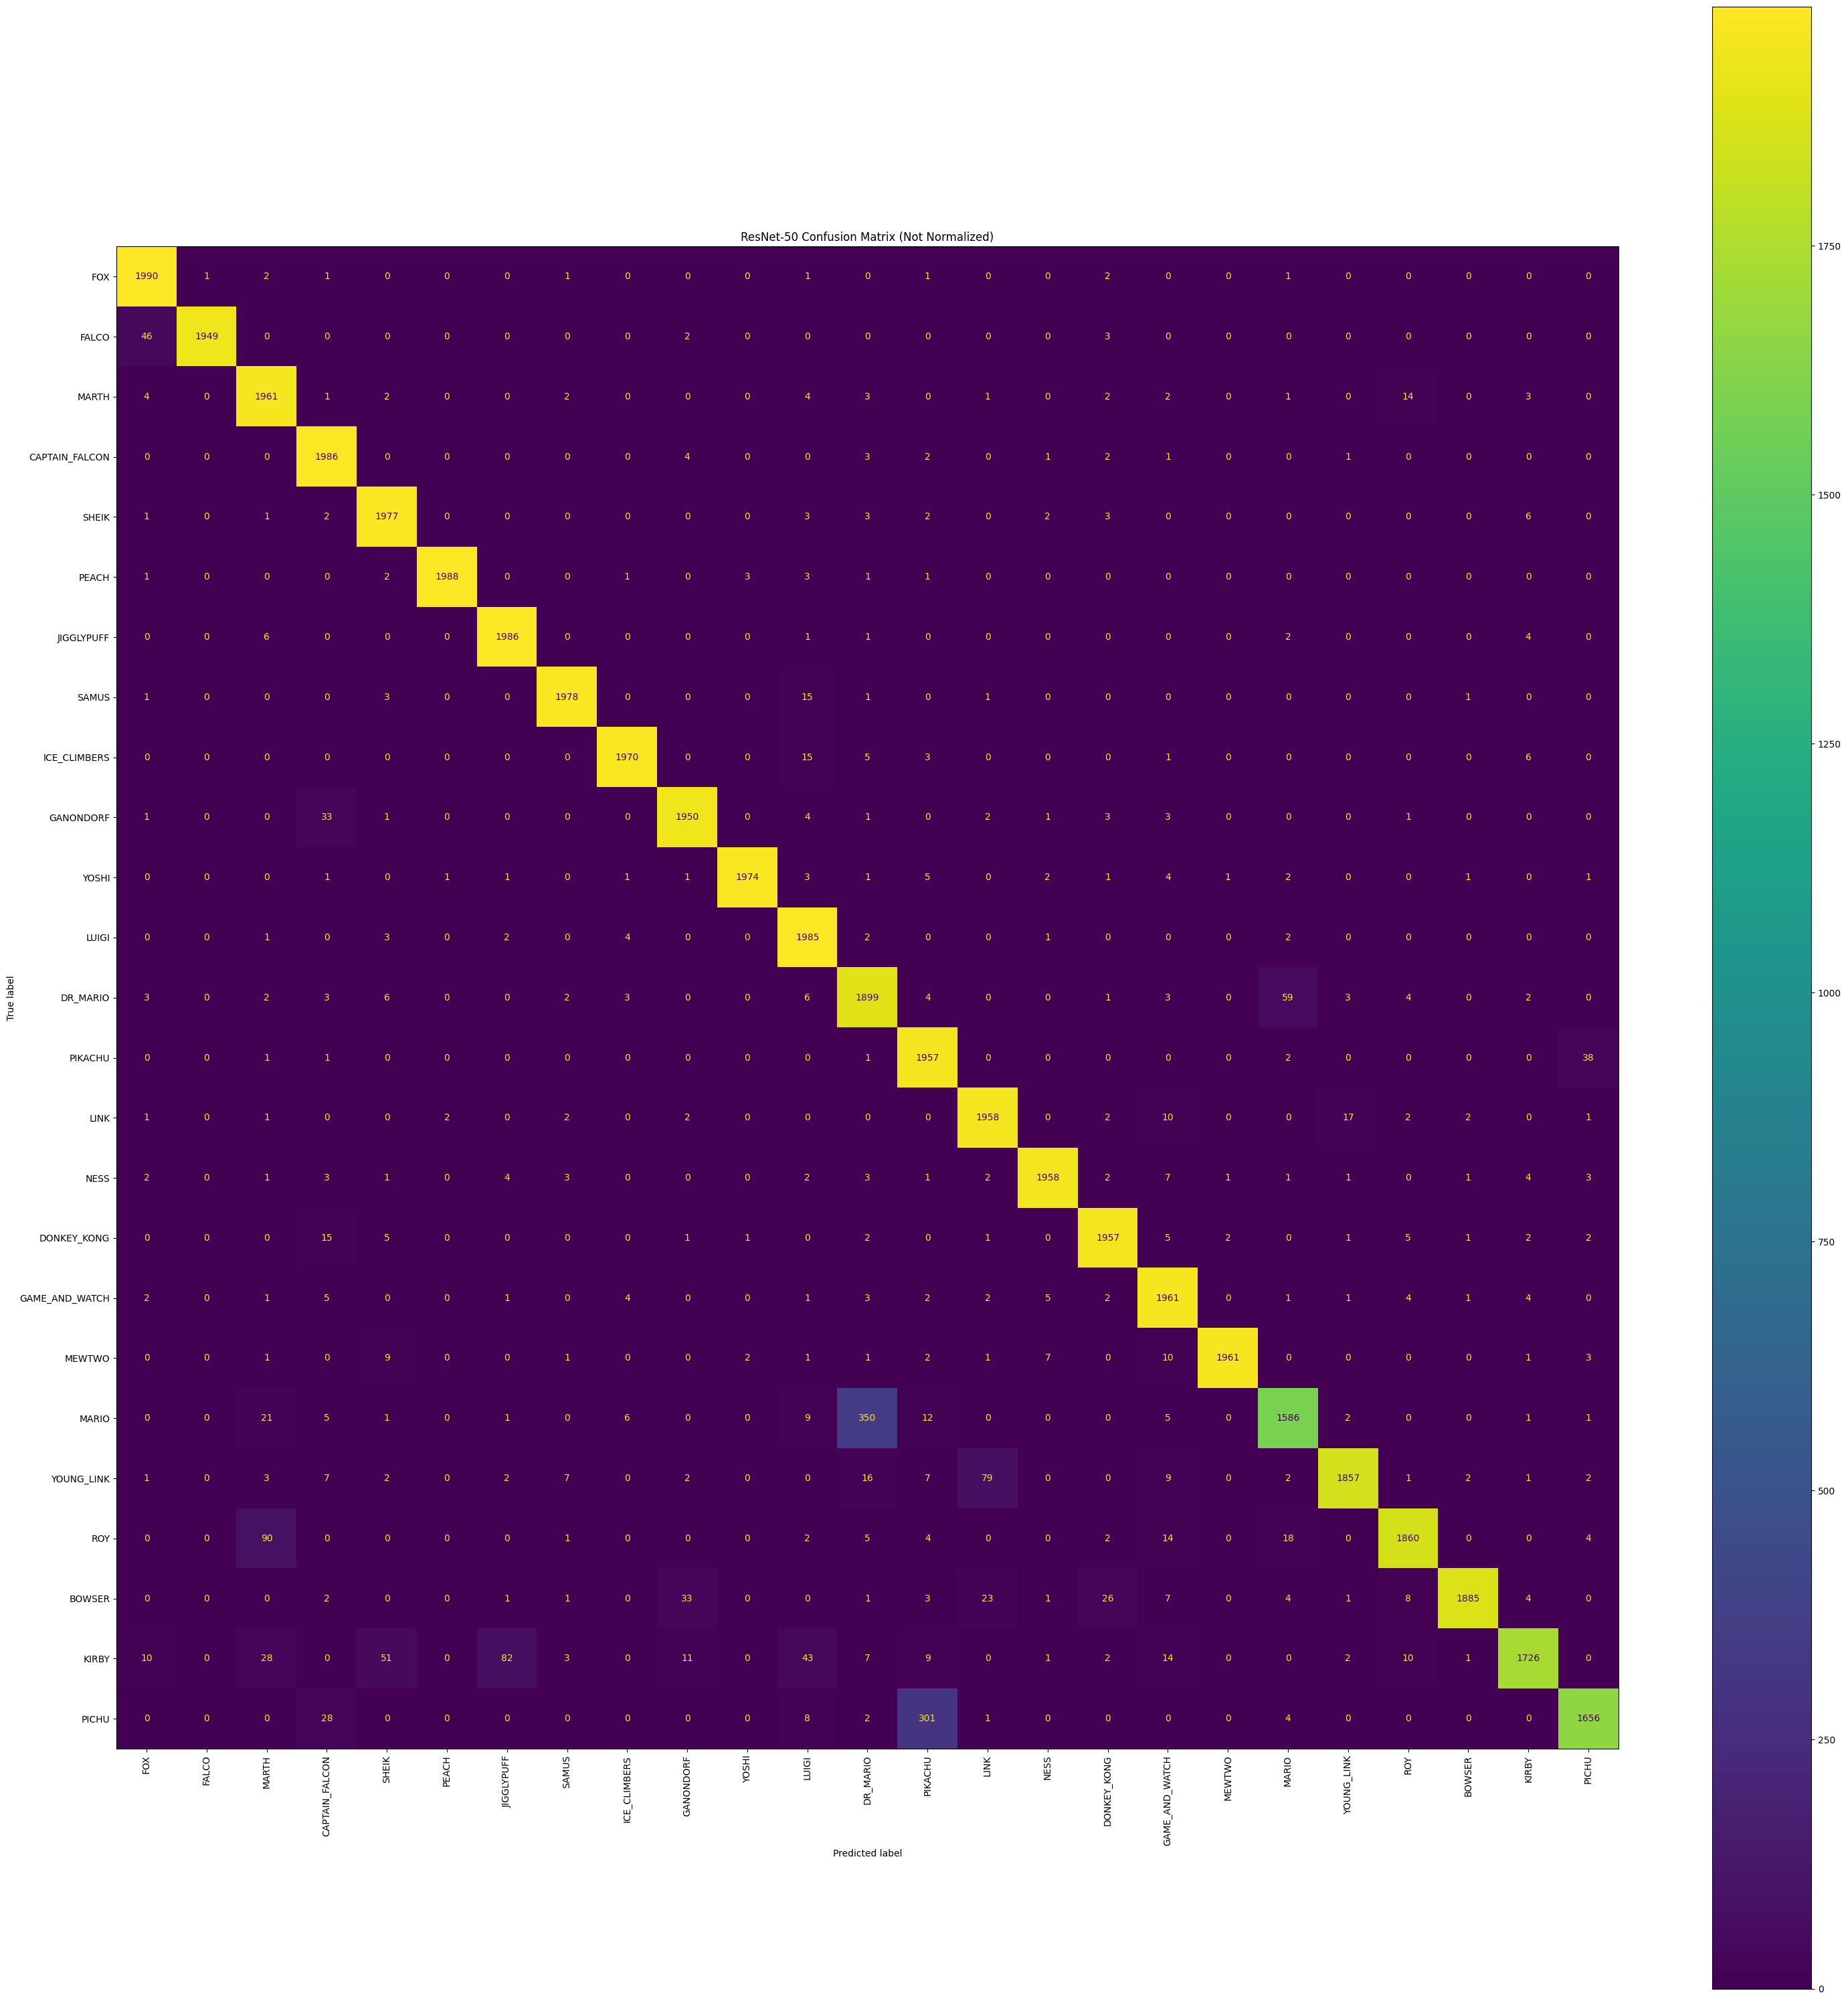

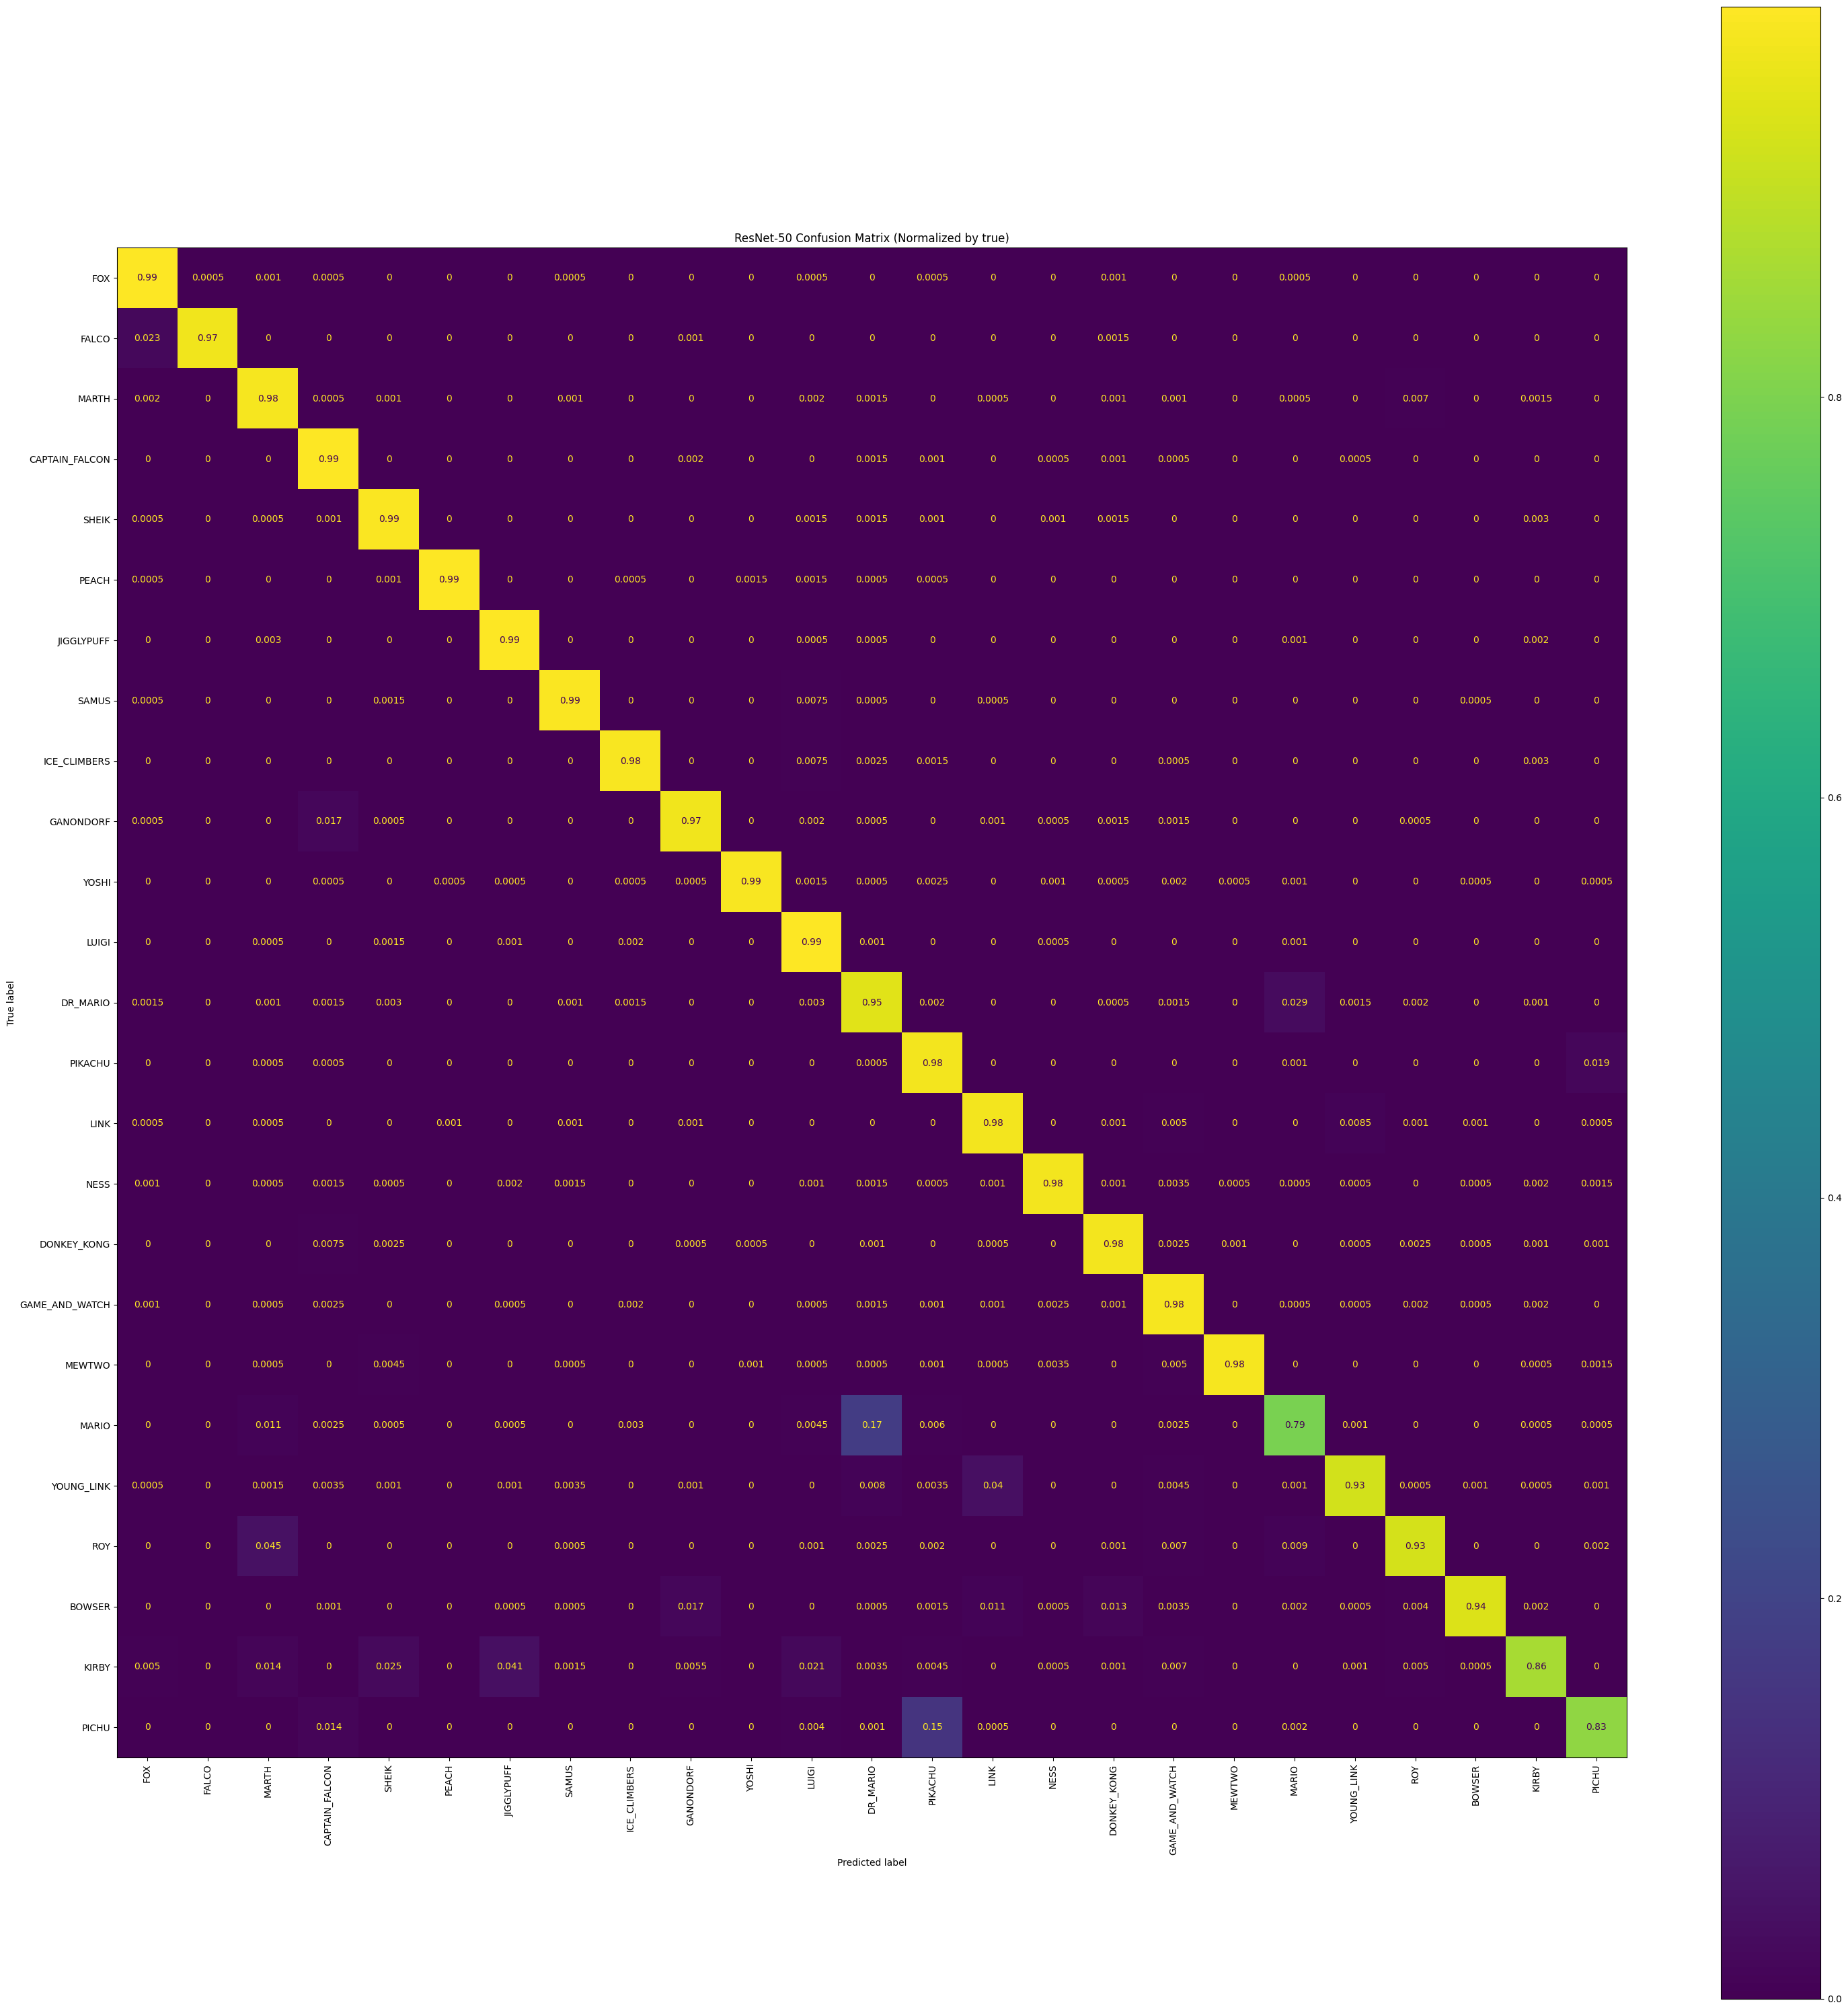

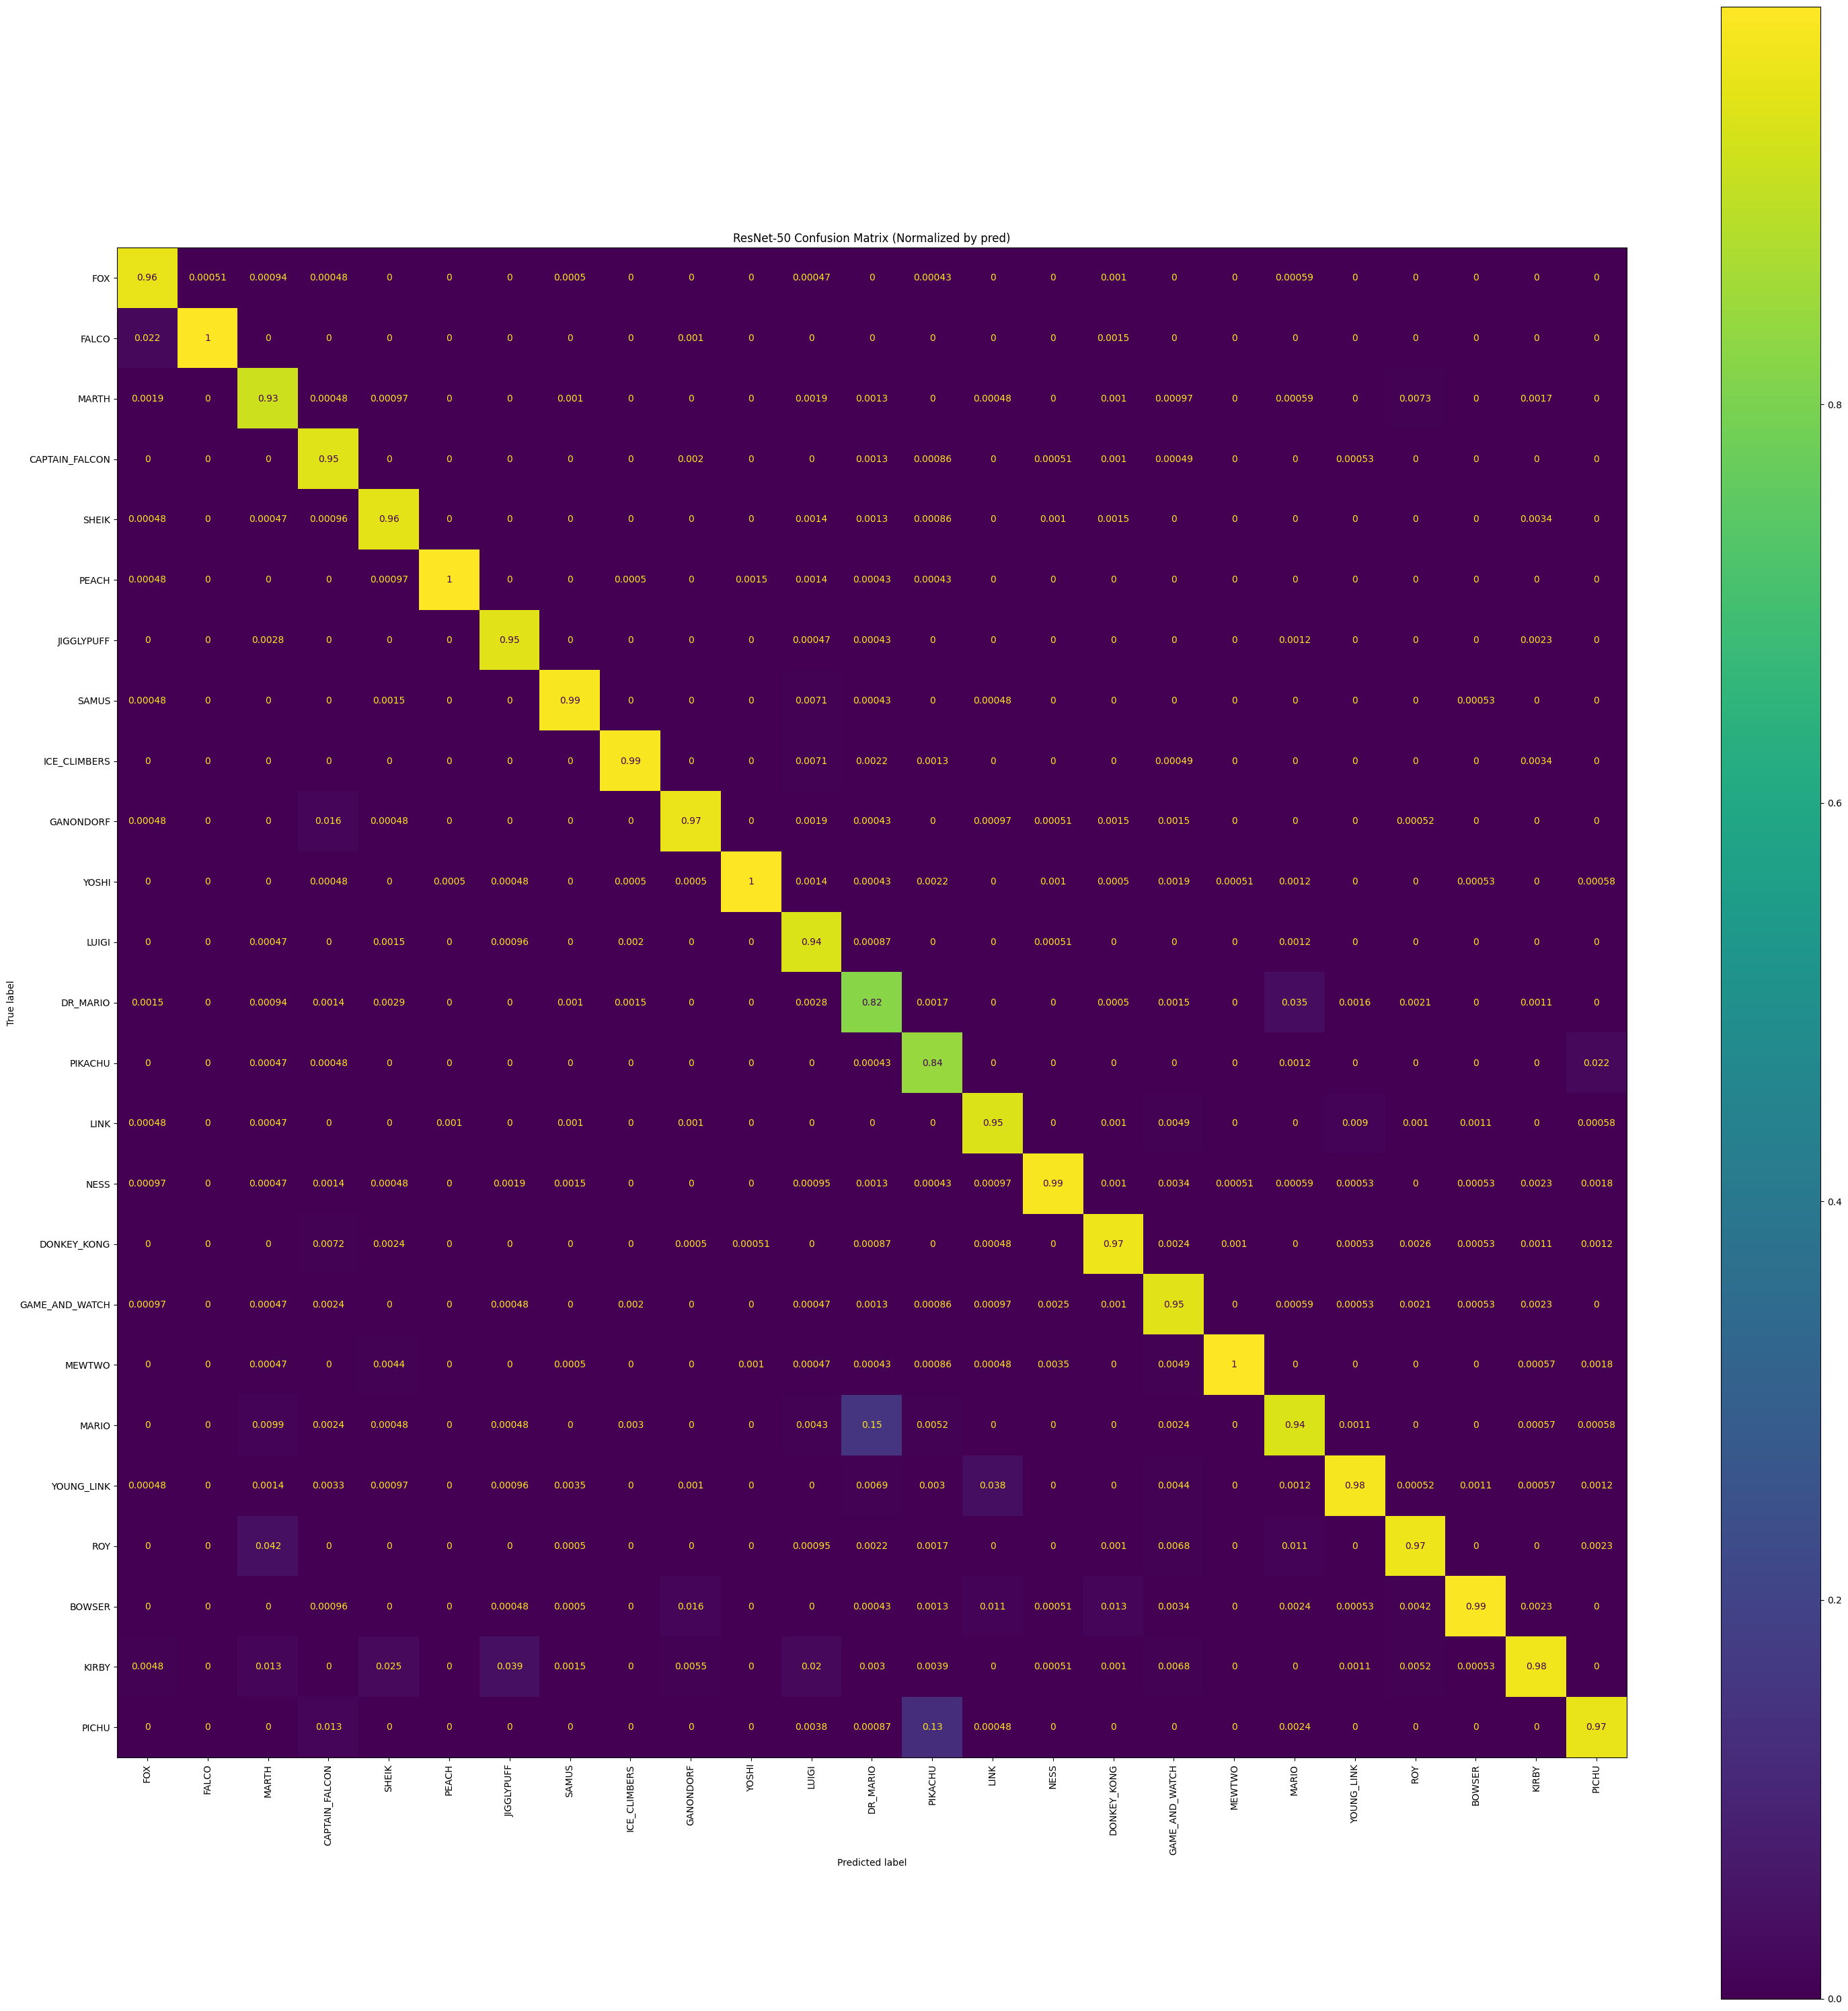

In [20]:
asses_model('ResNet-50', np.array([label_decoder.get(item, "Unknown") for item in y_pred]), np.array(test_df['labels']), labels_order)


In [21]:
x = [3, 4, 4]
plus = 3 + 2
multiplier = 4
for val in x:
    plus += multiplier * val
    multiplier *= 2
print(1 + 2 * plus)
    
# print(1 + 2 * (x[0] * 4 + x[1] * 8 + x[2] * 16 + x[3] * 32))

227


In [ ]:
slp_pytorch_functions.train_model(model, criterion,optimizer, loaders, 'cuda', 2 )
y_pred = slp_pytorch_functions.predict(model, loaders['test'], 'cuda' )
asses_model('ResNet-50', np.array([label_decoder.get(item, "Unknown") for item in y_pred]), np.array(test_df['labels']), labels_order)


Epoch 1/2:  12%|█▏        | 780/6250 [00:14<01:40, 54.56batch/s, accuracy=96.5, loss=0.109]

In [ ]:
slp_pytorch_functions.train_model(model, criterion,optimizer, loaders, 'cuda', 2 )
y_pred = slp_pytorch_functions.predict(model, loaders['test'], 'cuda' )
asses_model('ResNet-50', np.array([label_decoder.get(item, "Unknown") for item in y_pred]), np.array(test_df['labels']), labels_order)

In [ ]:
slp_pytorch_functions.train_model(model, criterion,optimizer, loaders, 'cuda', 2 )
y_pred = slp_pytorch_functions.predict(model, loaders['test'], 'cuda' )
asses_model('ResNet-50', np.array([label_decoder.get(item, "Unknown") for item in y_pred]), np.array(test_df['labels']), labels_order)

In [ ]:
asses_model('ResNet-50', np.array([label_decoder.get(item, "Unknown") for item in y_pred]), np.array(test_df['labels']), labels_order)